In [1]:
import pandas as pd
import sys
import os

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import mlflow
import xgboost as xgb

from mlflow import MlflowClient
from pprint import pprint
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer,confusion_matrix
from sklearn.svm import SVC

# MLFlow setup

In [2]:
client = MlflowClient(tracking_uri="http://127.0.0.1:8080")

In [ ]:
# Experiment description
experiment_description = (
    "OC - Projet 7 "
    "Implémentation d'un modèle de scoring pour des crédits"
)
experiment_tags = {
    "mlflow.note.content": experiment_description,
}

# Create the Experiment
scoring_experiment = client.create_experiment(
    name="Scoring_Models",tags=experiment_tags,artifact_location='s3://p7mlflowartifacts/20240405_artifacts/')

In [5]:
all_experiments = client.search_experiments()

print(all_experiments)

[<Experiment: artifact_location='mlflow-artifacts:/797535329160660179', creation_time=1711711422537, experiment_id='797535329160660179', last_update_time=1711711422537, lifecycle_stage='active', name='Scoring_Models', tags={'mlflow.note.content': "OC - Projet 7 Implémentation d'un modèle de scoring "
                        'pour des crédits'}>, <Experiment: artifact_location='mlflow-artifacts:/0', creation_time=1710501172953, experiment_id='0', last_update_time=1710501172953, lifecycle_stage='active', name='Default', tags={}>]


In [6]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
mlflow.set_experiment("Scoring_Models")

<Experiment: artifact_location='mlflow-artifacts:/797535329160660179', creation_time=1711711422537, experiment_id='797535329160660179', last_update_time=1711711422537, lifecycle_stage='active', name='Scoring_Models', tags={'mlflow.note.content': "OC - Projet 7 Implémentation d'un modèle de scoring "
                        'pour des crédits'}>

In [7]:
mlflow.sklearn.autolog()

2024/04/05 11:05:15 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.


# Data loading

In [8]:
sys.path.append(os.path.abspath(os.path.join('..')))

In [ ]:
from src.lightgbm_with_simple_features import main
from src.model_prep import get_initial_splits, get_grid_cv_scores,plot_metric_results

Lightgbm_with_simple_features kernel from kaggle ([link](https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script)) has been slightly modified and will be used for data preprocessing and feature engineering.
Modifications made are :
- Dropping columns with missing values.
- Replacing inf values due to division by zero with nans.

In [10]:
df=main()

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 33s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 50s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 26s
Installments payments df shape: (339587, 26)
Process installments payments - done in 41s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 53s
Dropping columns with missing values
Initial shape : (356251, 798)
Final shape : (356251, 182)


In [11]:
df

,index,SK_ID_CURR,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,INCOME_CREDIT_PERC,TARGET
0,0,100002,0,0,0,0,202500.0,406597.5,0.018801,-9461,...,False,False,False,False,True,False,True,False,0.498036,1.0
1,1,100003,1,0,1,0,270000.0,1293502.5,0.003541,-16765,...,False,False,False,False,False,False,True,False,0.208736,0.0
2,2,100004,0,1,0,0,67500.0,135000.0,0.010032,-19046,...,False,False,False,False,False,False,False,False,0.500000,0.0
3,3,100006,1,0,0,0,135000.0,312682.5,0.008019,-19005,...,False,False,False,False,False,False,False,False,0.431748,0.0
4,4,100007,0,0,0,0,121500.0,513000.0,0.028663,-19932,...,False,False,False,False,False,False,False,False,0.236842,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356250,48739,456221,1,0,0,0,121500.0,412560.0,0.002042,-19970,...,False,False,False,False,False,False,False,False,0.294503,NaN
356251,48740,456222,1,0,1,2,157500.0,622413.0,0.035792,-11186,...,False,False,False,False,False,False,False,False,0.253047,NaN
356252,48741,456223,1,1,0,1,202500.0,315000.0,0.026392,-15922,...,False,False,False,False,True,False,True,False,0.642857,NaN
356253,48742,456224,0,0,1,0,225000.0,450000.0,0.018850,-13968,...,False,False,False,True,False,False,True,False,0.500000,NaN


In [12]:
kaggle_df,X_train,X_test,y_train,y_test=get_initial_splits(df)

In [13]:
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

# Model selection

In [14]:
print(X_train_scaled.shape,y_train.shape)

(215254, 181) (215254,)


In [15]:
def custom_loss(y_true, y_pred):
    #FP = loan not given to good client, FN loan given to bad client.
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fn*10+fp

custom_score = make_scorer(custom_loss, greater_is_better=False)

### Dummy Baseline

In [15]:
model=DummyClassifier()
params={'classification__strategy':['most_frequent']}
_,results_dummy=get_grid_cv_scores(model,params,custom_score=custom_score,X_train=X_train_scaled,y_train=y_train)
results_dummy

2024/03/29 15:26:19 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'c7d28131272040f082925bd10ca647c6', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/03/29 15:26:19 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
c:\Users\blanc\AppData\Local\pypoetry\Cache\virtualenvs\projet7-PQQbXjaB-py3.11\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2024/03/29 15:26:47 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\blanc\AppData\Local\pypoetry\Cache\virtualenvs\projet7-PQQbXjaB-py3.11\Lib\site-packages\_dist

,mean_fit_time,params,mean_train_AUC,mean_train_Accuracy,mean_train_F1-score,mean_train_Custom_scorer,mean_test_AUC,mean_test_Accuracy,mean_test_F1-score,mean_test_Custom_scorer
0,2.879439,{'classification__strategy': 'most_frequent'},0.5,0.919272,0.0,-139016.0,0.5,0.919272,0.0,-34754.0


The dummy's accuracy score is very high (0.92) due to the classes imbalance. This shows the need for a custom score. 

### Logistic Regression

In [19]:
model=LogisticRegression(random_state=33)
params={'classification__penalty' : ['elasticnet', None], 'classification__l1_ratio':[0,0.2,0.5,0.7,1],'classification__C': [0.1,1,2,5, 10.]}
best_estimator_, results_lr=get_grid_cv_scores(model,params,custom_score=custom_score,X_train=X_train_scaled,y_train=y_train)

2024/03/29 15:47:02 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '43f6f3b9fcdf4bf585979a2b722170f4', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/03/29 15:47:02 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
c:\Users\blanc\AppData\Local\pypoetry\Cache\virtualenvs\projet7-PQQbXjaB-py3.11\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
c:\Users\blanc\AppData\Local\pypoetry\Cache\virtualenvs\projet7-PQQbXjaB-py3.11\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\blanc\AppData\Local\pypoetry\Cache\virtualenvs\projet7-PQQbXjaB-py3.11\Lib\site-packages\skl

In [21]:
best_estimator_

Pipeline(steps=[('sampling', SMOTE()),
                ('classification',
                 LogisticRegression(C=2, l1_ratio=0, penalty=None,
                                    random_state=33))])

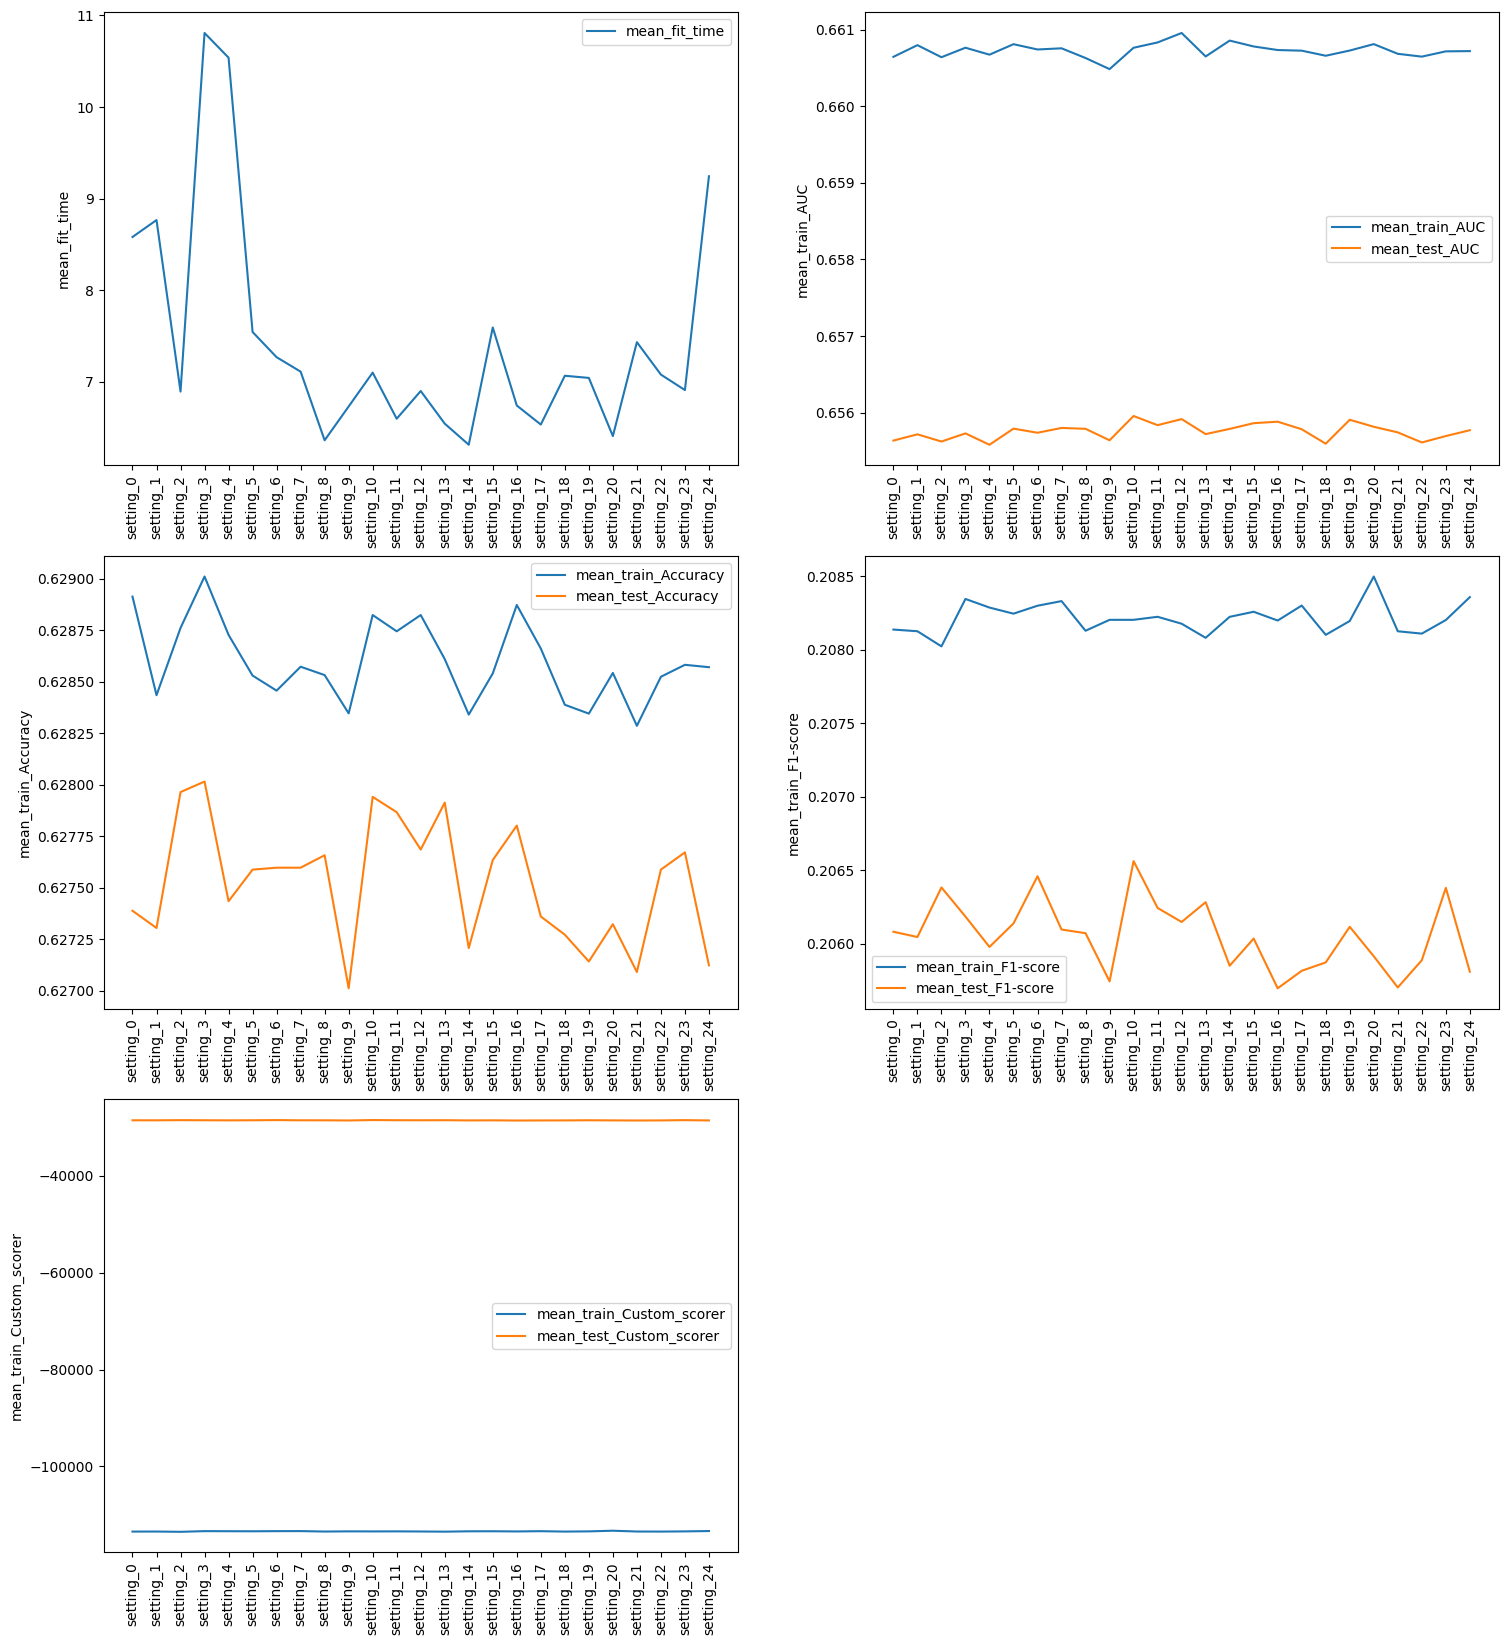

In [22]:
plot_metric_results(results_lr.dropna(axis=0))

### SVC with gaussian kernel

In [26]:
model=SVC(random_state=33)
params={'classification__kernel':['rbf'], 'classification__C':[0.01,1,10], 'classification__gamma':[0.1,0.5,1]}
best_estimator_, results_svc=get_grid_cv_scores(model,params,custom_score=custom_score,X_train=X_train_scaled,y_train=y_train)

2024/03/29 16:14:13 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '08869019b55848b78ee0937e5fa46597', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/03/29 16:14:14 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'


In [ ]:
results_svc.dropna(axis=0)

In [ ]:
plot_metric_results(results_svc.dropna(axis=0))

### Random Forest

In [16]:
model=RandomForestClassifier(random_state=33)
# First step is to select best n_estimators
params={'classification__n_estimators':[5,10,20,50,100,200,300],
        }
best_estimator_, results_rf=get_grid_cv_scores(model,params,custom_score=custom_score,X_train=X_train_scaled,y_train=y_train)

2024/04/05 11:09:04 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '6e740759a93047e3ae10b3327f7ea181', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/04/05 11:09:04 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2024/04/05 13:10:17 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\blanc\AppData\Local\pypoetry\Cache\virtualenvs\projet7-PQQbXjaB-py3.11\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils."
2024/04/05 13:10:21 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\blanc\AppData\Local\pypoetry\Cache\virtualenvs\projet7-PQQbXjaB-py3.11\Lib\site-packages\mlflow\sklearn\utils.py:790: UserWarning: Top 5 child runs will be created based on ordering in ra

In [17]:
best_estimator_

Pipeline(steps=[('sampling', SMOTE()),
                ('classification',
                 RandomForestClassifier(n_estimators=5, random_state=33))])

In [21]:
results_rf.dropna(axis=0)

,mean_fit_time,params,mean_train_AUC,mean_train_Accuracy,mean_train_F1-score,mean_train_Custom_scorer,mean_test_AUC,mean_test_Accuracy,mean_test_F1-score,mean_test_Custom_scorer
0,13.516789,{'classification__n_estimators': 5},0.995178,0.988381,0.924174,-17378.2,0.555557,0.896508,0.078027,-34036.6
1,27.502195,{'classification__n_estimators': 10},0.999840,0.991435,0.943996,-14706.8,0.573324,0.916067,0.023037,-34508.6
2,52.456654,{'classification__n_estimators': 20},0.999999,0.997534,0.984491,-4246.0,0.595841,0.918018,0.011204,-34628.0
3,122.537212,{'classification__n_estimators': 50},1.000000,0.999855,0.999100,-250.0,0.618108,0.918775,0.005006,-34696.2
4,188.311700,{'classification__n_estimators': 100},1.000000,0.999995,0.999971,-8.0,0.630909,0.918877,0.002969,-34724.2
5,291.834710,{'classification__n_estimators': 200},1.000000,1.000000,1.000000,0.0,0.639056,0.919035,0.003316,-34712.0
6,598.883601,{'classification__n_estimators': 300},1.000000,1.000000,1.000000,0.0,0.640841,0.918961,0.002516,-34727.8


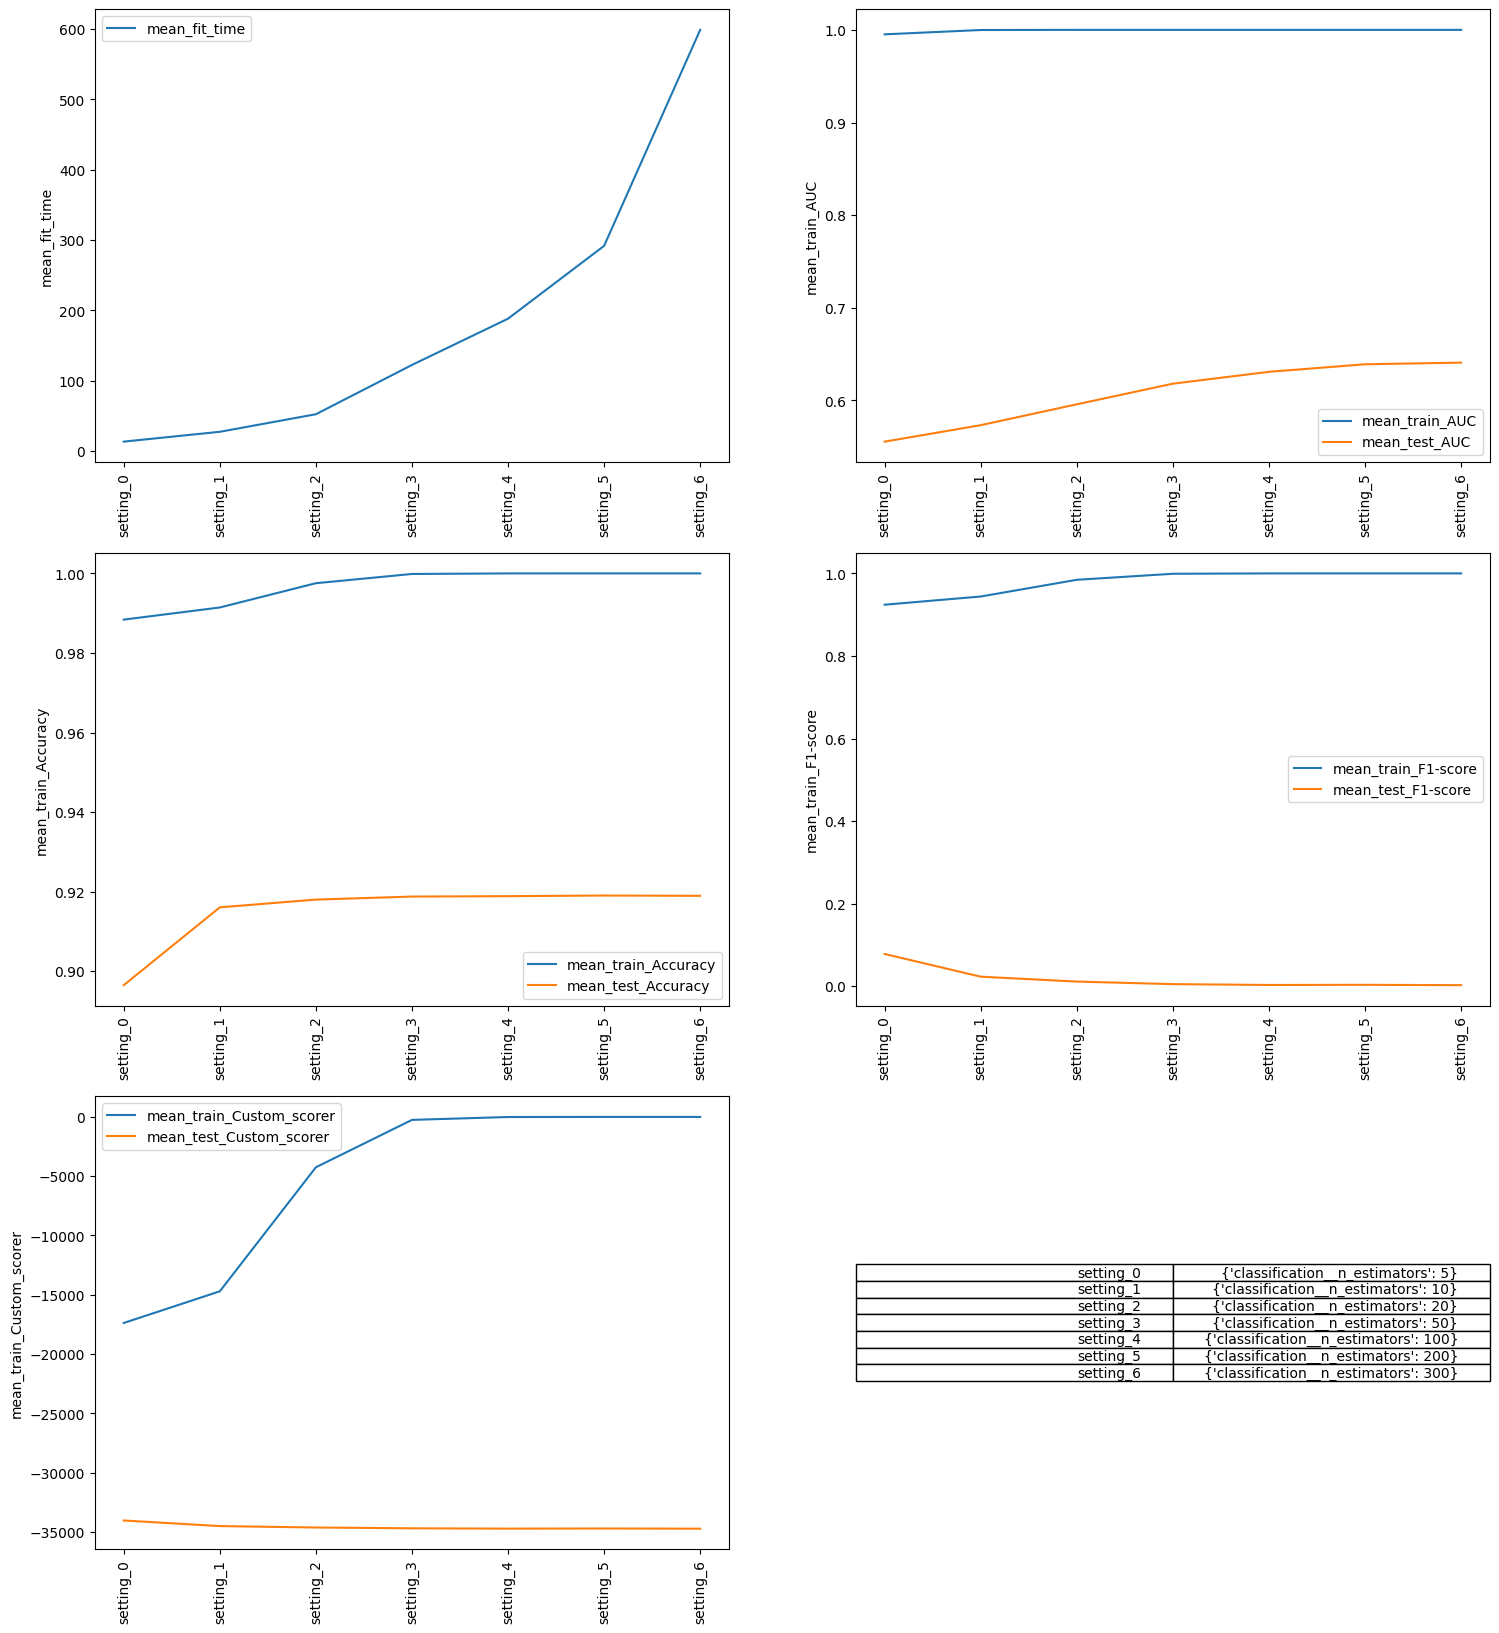

In [39]:
plot_metric_results(results_rf.dropna(axis=0))

In [40]:
model=RandomForestClassifier(random_state=33)
# Then the other parameters can be tested with the selected n_estimators
params={'classification__n_estimators':[50],
        'classification__min_samples_leaf':[1, 2, 4, 10,12,13,14,15,16, 20],
        'classification__max_depth':[3, 5, 10, 14, None],
        'classification__max_features':['log2', 'sqrt', None]
        }
best_estimator_, results_rf=get_grid_cv_scores(model,params,custom_score=custom_score,X_train=X_train_scaled,y_train=y_train)

2024/04/05 15:42:08 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'dcc19e1ffef943e1a0b3df415710cb9c', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/04/05 15:42:10 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'


### XGBoost

In [ ]:
#First step if determining best n_estimators with a high learning rate
model=XGBoost(random_state=33)
# Then the other parameters can be tested with the selected n_estimators
params= {'learning_rate' : [0.1],
        'n_estimators' : [40,60,80,100,150,250,300]}
best_estimator_, results_xgb=get_grid_cv_scores(model,params,custom_score=custom_score,X_train=X_train_scaled,y_train=y_train)

In [ ]:
results_xgb.dropna(axis=0)

In [ ]:
plot_metric_results(results_xgb.dropna(axis=0))